# Project Idea
In the recent past, the expansion of the COVID-19 pandemic has reshaped the world radically. Hospitals and medical centers have become a fertile ground for the spread of this virus, where patients are in close contact with someone with COVID-19. Social distancing plays a pivotal role in eliminating the spread of this virus. Hence, a new term appeared, which is telemedicine. Telemedicine is consulting patients by physicians remotely via vast communication technologies. However, the doctors' productivity may decrease due to the intense effort required to balance between in-patients and out-patients. Also, most people try to diagnose themselves by expressing their symptoms in the search engine. Then, they start reading from random unauthorized websites on the internet. On the contrary, this is not safe at all and may lead to the misclassification of the ailment.

This project aims to speed up the diagnosis process accurately using Natural Language Processing (NLP) models. The dataset that will be used contains more than 6000 text records of variant symptoms along with the type of the ailment. The first step in the proposed work is to perform text preprocessing techniques such as lemmatization, stop words removal and generating word embeddings. Then, deep neural networks will take word embeddings as inputs to predict the output (i.e., the ailment). However, deep learning methods suffer from the risk of getting stuck in local optima. This is because the values of weights are initialized randomly. Not only the weights but also their parameters. The Bees Algorithm (BA) is one of the swarm intelligence algorithms. It is a population-based algorithm as well as it mimics the behavior of the bees in foraging in nature. In the proposed work, the Bees algorithm is used along with deep learning models to enhance the process of hyper-parameter tuning so that the overall performance of classifying unstructured medical text can be improved.

# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# Load dataset
https://www.kaggle.com/datasets/paultimothymooney/medical-speech-transcription-and-intent

In [2]:
ailments_data = pd.read_csv('ailments.csv', encoding="ISO-8859-1")

print(ailments_data.shape)

ailments_data = ailments_data.drop_duplicates()
print(ailments_data.shape)

print("Missing values: ", ailments_data.isnull().sum())

ailments_data.info()

ailments_data.head()


(6661, 2)
(707, 2)
Missing values:  phrase    0
prompt    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 707 entries, 0 to 3271
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   phrase  707 non-null    object
 1   prompt  707 non-null    object
dtypes: object(2)
memory usage: 16.6+ KB


,phrase,prompt
0,When I remember her I feel down,Emotional pain
1,When I carry heavy things I feel like breaking...,Hair falling out
2,there is too much pain when i move my arm,Heart hurts
3,My son had his lip pierced and it is swollen a...,Infected wound
4,My muscles in my lower back are aching,Infected wound


# Text Augmentation

In [3]:
import nlpaug.augmenter.sentence as nas
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
%pip install nlpaug


def dataAugFun(ailments_data, N):

    aug_data = ailments_data.head(0)

    texts = ailments_data['phrase']
    for ind in ailments_data.index:
        texts = ailments_data['phrase'][ind]
        label = ailments_data['prompt'][ind]
        aug = naw.RandomWordAug(action="swap")
        # aug = naw.SynonymAug(aug_src='wordnet')
        augmented_text = aug.augment(texts, n=N)

        for string in augmented_text:
            aug_data = aug_data.append({'phrase': string,
                                        'prompt': label},
                                       ignore_index=True)

    return aug_data


Note: you may need to restart the kernel to use updated packages.


/home/mai.kassem/.conda/envs/myenv2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ailments_data = dataAugFun(ailments_data, 4)

ailments_data

ailments_data.to_csv('aug_ailments_data.csv', index=False)


# EDA

## Class distribution

<AxesSubplot:>

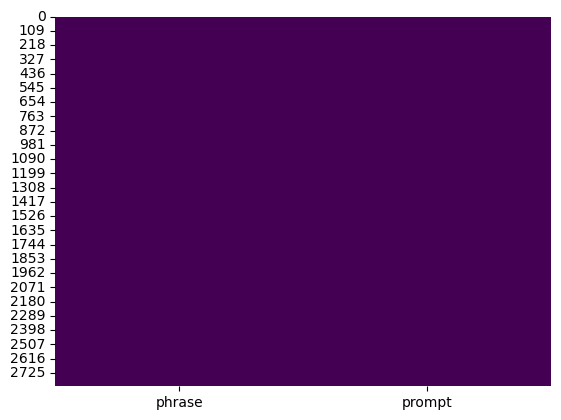

In [5]:
# Visualizing the missing data
sns.heatmap(ailments_data.isnull(), cbar=False, cmap='viridis')


In [6]:
# Number of ailments
print('Number of categories: ', ailments_data['prompt'].nunique())

# Print class distribution
counter = Counter(ailments_data['prompt'])
for k, v in counter.items():
    per = v / len(ailments_data['prompt']) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))


Number of categories:  25
Class=Emotional pain, n=96 (3.395%)
Class=Hair falling out, n=112 (3.960%)
Class=Heart hurts, n=124 (4.385%)
Class=Infected wound, n=136 (4.809%)
Class=Foot ache, n=108 (3.819%)
Class=Shoulder pain, n=140 (4.950%)
Class=Injury from sports, n=108 (3.819%)
Class=Skin issue, n=116 (4.102%)
Class=Stomach ache, n=108 (3.819%)
Class=Knee pain, n=128 (4.526%)
Class=Joint pain, n=136 (4.809%)
Class=Hard to breath, n=100 (3.536%)
Class=Head ache, n=108 (3.819%)
Class=Body feels weak, n=104 (3.678%)
Class=Feeling dizzy, n=104 (3.678%)
Class=Back pain, n=108 (3.819%)
Class=Open wound, n=88 (3.112%)
Class=Internal pain, n=104 (3.678%)
Class=Blurry vision, n=104 (3.678%)
Class=Acne, n=136 (4.809%)
Class=Muscle pain, n=116 (4.102%)
Class=Neck pain, n=100 (3.536%)
Class=Cough, n=124 (4.385%)
Class=Ear ache, n=112 (3.960%)
Class=Feeling cold, n=108 (3.819%)


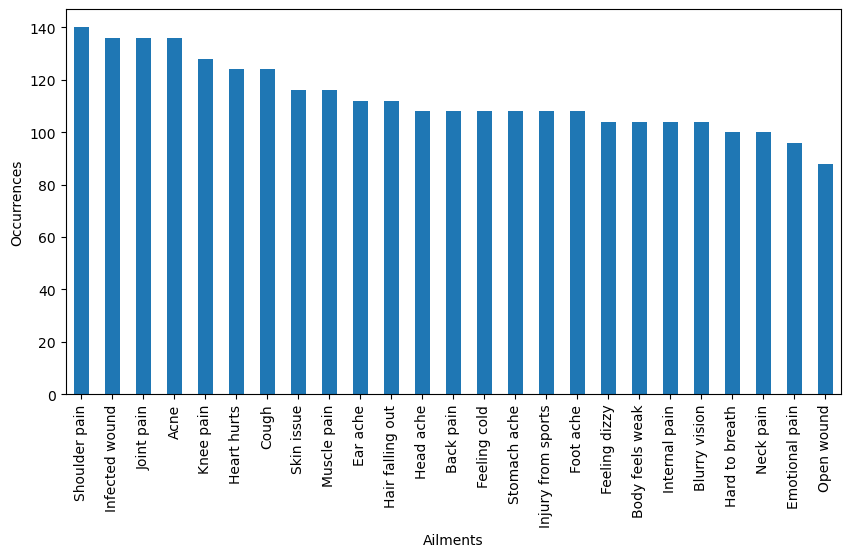

In [7]:
plt.figure(figsize=(10, 5))
ailments_data['prompt'].value_counts().plot(kind='bar')
plt.xlabel('Ailments')
plt.ylabel('Occurrences')
plt.show()


==> ***Dataset is balanced***

# Data Preprocessing

In [8]:
from sklearn import preprocessing
import numpy
# Convert labels to numbers
le = preprocessing.LabelEncoder()
le.fit(ailments_data['prompt'])

le.classes_


y = le.transform(ailments_data['prompt'])
# print(le.inverse_transform(y))


# compare before and after
print(ailments_data['prompt'].value_counts())
unique, counts = numpy.unique(y, return_counts=True)
afterEncoder = dict(zip(unique, counts))
dict(sorted(afterEncoder.items(), key=lambda item: item[1], reverse=True))


Shoulder pain         140
Infected wound        136
Joint pain            136
Acne                  136
Knee pain             128
Heart hurts           124
Cough                 124
Skin issue            116
Muscle pain           116
Ear ache              112
Hair falling out      112
Head ache             108
Back pain             108
Feeling cold          108
Stomach ache          108
Injury from sports    108
Foot ache             108
Feeling dizzy         104
Body feels weak       104
Internal pain         104
Blurry vision         104
Hard to breath        100
Neck pain             100
Emotional pain         96
Open wound             88
Name: prompt, dtype: int64


{22: 140,
 0: 136,
 14: 136,
 17: 136,
 18: 128,
 4: 124,
 13: 124,
 19: 116,
 23: 116,
 5: 112,
 10: 112,
 1: 108,
 7: 108,
 9: 108,
 12: 108,
 15: 108,
 24: 108,
 2: 104,
 3: 104,
 8: 104,
 16: 104,
 11: 100,
 20: 100,
 6: 96,
 21: 88}

In [9]:
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
%pip install nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


def text_transform(message):

    # (a) change the message to lowercase
    message = message.lower()

    # (b) tokenize the message,
    # i.e. if input = 'i am a student.'
    # then, output  = ['i', 'am', 'a', 'student', '.']
    message = nltk.word_tokenize(message)

    # (c) remove special characters in the message
    msg_temp = []
    for word in message:
        # only accpet the alpha-numeric words and remove all other cases e.g. special characters
        if word.isalnum():
            msg_temp.append(word)

    message = msg_temp

    # (d) remove stopwords and punctuations
    msg_temp = []
    for word in message:
        if word not in stopwords.words('english') and word not in string.punctuation:
            msg_temp.append(word)

    message = msg_temp

    # (e) lemmatization function
    lemmatizer = WordNetLemmatizer()
    msg_temp = []
    for word in message:
        msg_temp.append(lemmatizer.lemmatize(word))

    # join all words with space and return new message
    new_message = " ".join(msg_temp)

    return new_message


ailments_data
# apply the pre-processing steps via text_transform() function on text data
ailments_data['transformed_phrase'] = ailments_data['phrase'].apply(
    text_transform)

X = ailments_data.transformed_phrase
X.tail()


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /home/mai.kassem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mai.kassem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mai.kassem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mai.kassem/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


2823               wound surgical infection
2824    swelling redness difficulty walking
2825    redness swelling difficulty walking
2826    redness swelling walking difficulty
2827    redness swelling walking difficulty
Name: transformed_phrase, dtype: object

In [10]:
# count unique words

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(ailments_data['transformed_phrase'])


num_unique_words = len(counter)
print("Total number of unique words : " + str(num_unique_words))

print(counter)


Total number of unique words : 971
Counter({'feel': 764, 'pain': 712, 'like': 220, 'hurt': 212, 'get': 192, 'back': 180, 'knee': 152, 'shoulder': 148, 'ache': 140, 'hair': 132, 'cold': 124, 'foot': 120, 'head': 116, 'ear': 112, 'skin': 108, 'lot': 108, 'body': 108, 'neck': 108, 'stomach': 104, 'time': 96, 'wound': 96, 'heart': 96, 'muscle': 92, 'joint': 88, 'hard': 84, 'sharp': 80, 'walk': 80, 'every': 80, 'stand': 80, 'breath': 76, 'dizzy': 76, 'cut': 72, 'acne': 72, 'cough': 72, 'arm': 68, 'left': 68, 'face': 68, 'feeling': 68, 'go': 68, 'infected': 64, 'something': 64, 'day': 64, 'chest': 60, 'great': 60, 'inside': 56, 'think': 56, 'vision': 56, 'heavy': 52, 'much': 52, 'weak': 52, 'tried': 52, 'red': 52, 'move': 48, 'even': 48, 'see': 48, 'sensation': 48, 'morning': 48, 'falling': 48, 'playing': 44, 'football': 44, 'problem': 44, 'try': 44, 'since': 44, 'blurry': 44, 'pimple': 44, 'eat': 44, 'look': 40, 'ankle': 40, 'make': 40, 'still': 40, 'open': 40, 'sore': 40, 'right': 40, 'tak

In [11]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence


def get_max_input_length(docs):
    max_input_length = 1
    for document in docs:
        words = text_to_word_sequence(document)
        document_length = len(words)
        if document_length > max_input_length:
            max_input_length = document_length

    return max_input_length


# Training & Evaluating

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Vectorize a text corpus by turning each text into a sequence of integers

tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(X)

# Each word has a unique index

word_index = tokenizer.word_index

word_index


{'feel': 1,
 'pain': 2,
 'like': 3,
 'hurt': 4,
 'get': 5,
 'back': 6,
 'knee': 7,
 'shoulder': 8,
 'ache': 9,
 'hair': 10,
 'cold': 11,
 'foot': 12,
 'head': 13,
 'ear': 14,
 'skin': 15,
 'lot': 16,
 'body': 17,
 'neck': 18,
 'stomach': 19,
 'time': 20,
 'wound': 21,
 'heart': 22,
 'muscle': 23,
 'joint': 24,
 'hard': 25,
 'sharp': 26,
 'walk': 27,
 'every': 28,
 'stand': 29,
 'breath': 30,
 'dizzy': 31,
 'cut': 32,
 'acne': 33,
 'cough': 34,
 'arm': 35,
 'left': 36,
 'face': 37,
 'feeling': 38,
 'go': 39,
 'infected': 40,
 'something': 41,
 'day': 42,
 'chest': 43,
 'great': 44,
 'inside': 45,
 'think': 46,
 'vision': 47,
 'heavy': 48,
 'much': 49,
 'weak': 50,
 'tried': 51,
 'red': 52,
 'move': 53,
 'even': 54,
 'see': 55,
 'sensation': 56,
 'morning': 57,
 'falling': 58,
 'playing': 59,
 'football': 60,
 'problem': 61,
 'try': 62,
 'since': 63,
 'blurry': 64,
 'pimple': 65,
 'eat': 66,
 'look': 67,
 'ankle': 68,
 'make': 69,
 'still': 70,
 'open': 71,
 'sore': 72,
 'right': 73,
 't

In [13]:
# Max number of words in a sequence
max_length = get_max_input_length(X)
print("max_length: ", max_length)

train_sequences = tokenizer.texts_to_sequences(X)


max_length:  13


In [14]:
# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(train_sequences, maxlen=max_length,
                  padding='post', truncating='post')


In [15]:
# LSTM model

from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold

# define 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
fold_num = 1
for train, test in kfold.split(X, y):
    # Create model
    model = keras.models.Sequential()
    model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))
    model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(layers.Dense(25, activation="softmax"))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    # Fit the model
    print("Training fold number: ", fold_num)
    model.fit(X[train], y[train], epochs=20, batch_size=10, verbose=0)
    # Evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    fold_num = fold_num + 1

print("Average score: %.2f%%" % (np.mean(cvscores)))


2022-10-28 07:04:34.611774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 07:04:34.613573: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Training fold number:  1
accuracy: 97.88%
Training fold number:  2
accuracy: 95.76%
Training fold number:  3
accuracy: 95.41%
Training fold number:  4
accuracy: 92.93%
Training fold number:  5
accuracy: 96.11%
Training fold number:  6
accuracy: 98.59%
Training fold number:  7
accuracy: 96.11%
Training fold number:  8
accuracy: 96.82%
Training fold number:  9
accuracy: 98.23%
Training fold number:  10
accuracy: 97.87%
Average score: 96.57%


In [16]:
# TODO save model
# model.save("LSTM")

# from tensorflow.keras import models
# model = models.load_model("LSTM")

# scores = model.evaluate(X[test], y[test], verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


In [ ]:
# TODO apply other models

# Bees Algorithm (Hyper-parameter tuning)

In [ ]:
# TODO apply bees algorithm to select best hyper-parameters for LSTM